In [44]:
from pyspark import SparkContext
import numpy as np
import matplotlib.pyplot as pyplot
sc = SparkContext.getOrCreate()

In [45]:
icm = sc.textFile("../icm.csv")
icm = icm.map(lambda l: l.split(','))\
            .filter(lambda line: line[0] != 'itemId')\
            .map(lambda x: (int(x[0]), int(x[1])))

In [46]:
#AVG FEATURE PER ITEM

featPerItem= icm.map(lambda x: (x[0],[x[1]]))\
                .reduceByKey(lambda x,y: x+y)\
                .map(lambda x:(x[0],len(x[1])))
featNumbers = featPerItem.map(lambda x: x[1])  #Just the number of features for each item (without the item itself)
avgFeatures = featNumbers.mean()
maxFeatures = featNumbers.max()
minFeatures = featNumbers.min()
print("Average features per item: ", avgFeatures)
print("Highest features number for an item: ", maxFeatures)
print("Lowest features number per item: ", minFeatures)

36797
Average features per item:  5.150338342799682
Highest features number for an item:  40
Lowest features number per item:  1
36797


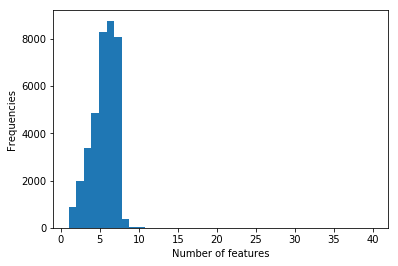

In [47]:
#Plot n° of feature - n°of items
x=featNumbers.collect()
NFeaturesNItems= featPerItem.map(lambda x: (x[1],1))\
                            .reduceByKey(lambda x,y: x+y)\
                            .sortBy(lambda x: x[0],ascending=True)
NFeaturesNItems.collect()
#Plotting
#x=NFeaturesNItems.map(lambda x: x[0]).collect()
#print(x)
#y=NFeaturesNItems.map(lambda x: x[1]).collect()
pyplot.hist(x,bins=max(x),histtype='bar')
pyplot.xlabel("Number of features")
pyplot.ylabel("Frequencies")
pyplot.show()

In [63]:
#User/Item interactions on train set
interactions=sc.textFile("../train.csv").map(lambda x: tuple(x.split(","))).filter(lambda x: "userId" not in x[0])
numInteractions=interactions.count()

In [64]:
itemList = interactions.map(lambda x: x[1]).distinct()
userList = interactions.map(lambda x: x[0]).distinct()
numUsers = userList.count()
numItems = itemList.count()

In [65]:
print ("The number of intereactions is {}".format(numInteractions))
print("Number of item in the trainset: {}".format(numItems))
print("Number of user in the trainset: {}".format(numUsers))
print("Sparsity of the matrix: {:.3f} %".format((1-(numInteractions)/(numItems*numUsers))*100))
print("Avg numerber of interactions per user: {}".format(numInteractions/numUsers))
print("Avg numerber of interactions per item: {}".format(numInteractions/numItems))

The number of intereactions is 170149
Number of item in the trainset: 33557
Number of user in the trainset: 15373
Sparsity of the matrix: 99.967 %
Avg numerber of interactions per user: 11.068041371235283
Avg numerber of interactions per item: 5.070447298626218


Min interactions: 1
Max interactions: 1695


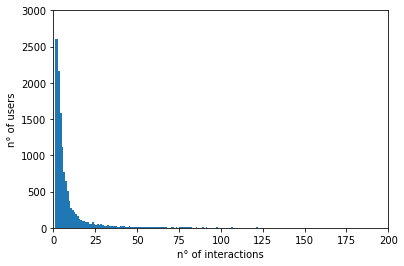

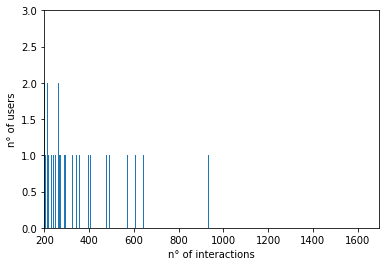

In [115]:
#Interaction analysis
perUserInteractions=interactions.map(lambda x: (x[0],1)).reduceByKey(lambda x,y: x+y)
data=perUserInteractions.map(lambda x: x[1]).collect()
minInt=min(data)
maxInt=max(data)
print("Min interactions: {}".format(minInt))
print("Max interactions: {}".format(maxInt))

pyplot.figure(1)
pyplot.hist(data,bins=np.arange(minInt,maxInt),histtype='bar')
pyplot.axis([0,200,0,3000])
pyplot.xlabel("n° of interactions")
pyplot.ylabel("n° of users")
pyplot.show()

pyplot.figure(2)
pyplot.hist(data,bins=np.arange(minInt,maxInt),histtype='bar')
pyplot.axis([200,maxInt,0,3])
pyplot.xlabel("n° of interactions")
pyplot.ylabel("n° of users")
pyplot.show()


In [93]:
#Define 3 gategories, <10 interactions ,10-50, >50

def assignCategory(interactionsNumber):
    if interactionsNumber<=5:
        return 1
    elif 6 <= interactionsNumber <=10:
        return 2
    elif 11 <= interactionsNumber <=30:
        return 3
    elif 30 <= interactionsNumber <=50:
        return 4
    else:
        return 5
catMap = {1:"1-5",2:"6-10",3:"11-30",4:"30-50",5:">50"}

userCategory=perUserInteractions.map(lambda x: (assignCategory(x[1]),1)).reduceByKey(lambda x,y: x+y)
catFreq=userCategory.takeOrdered(userCategory.count(),lambda x: x[0])
print("Interactions per category")
for elem in catFreq:
    print("{} : {} users".format(catMap[elem[0]],elem[1]))

Interactions per category
1-5 : 10056 users
6-10 : 2565 users
11-30 : 1862 users
30-50 : 360 users
>50 : 530 users


In [75]:
#Users on test set
testUsers=sc.textFile("../target_user.csv").filter(lambda x: "userId" not in x[0])
users=userList.collect()
numberNewUsers=testUsers.filter(lambda x: x not in users).count()

In [76]:
print("Number of new users: {}".format(numberNewUsers))

Number of new users: 1
